# Data anaylsis in cerebellar granular layer simulations
## Running the simulation

First, we set current working directory to the root of Spiking Granular Layer and insert the source folder to the python path:

In [1]:
import os
os.chdir('../../')
os.getcwd()
import sys
import numpy
%matplotlib inline
import matplotlib.pyplot as plt
sys.path.insert(1,'./src')

Now start setting a new simulation with the configuration file that we specify:

In [2]:
config_file = './config/GoCGrC/SimulationConfigAll4.cfg'
simulation_time = 500.0
import SpikingSimulation.FrequencySimulation as FrequencySimulation
simulation = FrequencySimulation.FrequencySimulation(config_file=config_file)

Initialize the simulation

In [3]:
simulation.config_options['simulation']['verbosity'] = 'Info'
simulation.config_options['simulation']['seed'] = 123456
simulation.config_options['simulation']['time'] = simulation_time
simulation.config_options['simulation']['register_activity_only_in_test'] = False
simulation.config_options['network']['load_file'] = './results/GoCGrC/network01_4mf_after_all_learning.h5'
simulation.config_options['network']['save_file'] = None
simulation.config_options['stimulation']['load_pattern_file'] = './results/GoCGrC/stimulation_all4.h5'
simulation.config_options['stimulation']['save_pattern_file'] = None
simulation.config_options['grclayer']['register_activity'] = True
simulation.config_options['goclayer']['register_activity'] = True
simulation.config_options['grclayer']['load_state_vars'] = 'Vth'
simulation.config_options['goclayer']['load_state_vars'] = 'Vth'
simulation.config_options['grclayer']['record_vars'] = None
simulation.config_options['goclayer']['record_vars'] = None
simulation.config_options['grclayer']['record_step'] = 1.0e-1
simulation.config_options['goclayer']['record_step'] = 1.0e-1
simulation.initialize()

2017-01-12 14:14:30,413 - P92024 - MemTotal:83M - Simulation - WARNING: Non-specified cell model parameter: tau_minus in layer mflayer. Using default value
2017-01-12 14:14:30,432 - P92024 - MemTotal:83M - Simulation - WARNING: Non-specified number of neurons in layer mflayer
2017-01-12 14:14:30,434 - P92024 - MemTotal:83M - Simulation - WARNING: Non-specified number of neurons in layer grclayer
2017-01-12 14:14:30,439 - P92024 - MemTotal:84M - Simulation - WARNING: Non-specified number of neurons in layer goclayer
2017-01-12 14:14:30,442 - P92024 - MemTotal:84M - Simulation - WARNING: tau_minus cannot be calculated in layer mflayer. Variable tau_minus is not defined. Using default value 20.0
2017-01-12 14:14:30,444 - P92024 - MemTotal:84M - Simulation - WARNING: tau_minus_triplet cannot be calculated in layer mflayer. Variable tau_istdp is not defined. Using default value 110.0


/Users/jgarrido/NEST/nest210/ins_nompi/lib/python2.7/site-packages/nest/lib/hl_api_helper.py:61: UserWarning: 
OneToOneConnect is deprecated and will be removed in a future version of NEST.
Please use Connect instead!
For details, see http://www.nest-simulator.org/connection_management                       


2017-01-12 14:14:34,412 - P92024 - MemTotal:246M - Simulation - INFO: Loading activation patterns from hdf5 file ./results/GoCGrC/stimulation_all4.h5


Visualize the simulation or only run it.

In [4]:
#simulation.visualize_animation()
simulation.run_simulation()

2017-01-12 14:14:52,536 - P92024 - MemTotal:284M - Simulation - INFO: Running the simulation from 0.0s until time 500.0s


Save the network state after the simulation

In [5]:
simulation.cerebellum.update_network_weights()
#simulation.cerebellum.save_network()

## GrC activity analysis

Calculate the average firing frequency of each granular cells during the ending 100 seconds

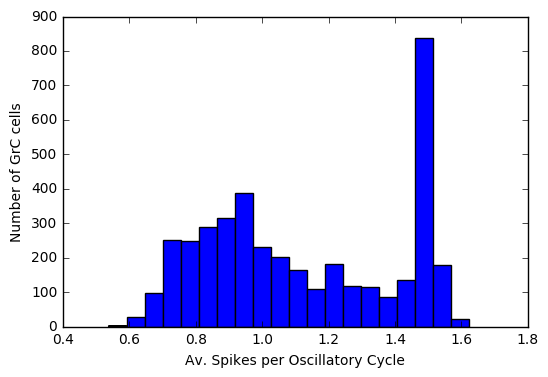

In [6]:
gtime,gcell_id = simulation.cerebellum.get_spike_activity(neuron_layer = 'grclayer',
                                                          init_time = simulation.current_time-simulation_time, 
                                                          end_time = simulation.current_time)
import numpy
firing_frequency = numpy.bincount(gcell_id) / (simulation_time*8.0)
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(firing_frequency, bins=20)
plt.ylabel('Number of GrC cells')
plt.xlabel('Av. Spikes per Oscillatory Cycle')

Get the histogram of input synapses for the granular cells

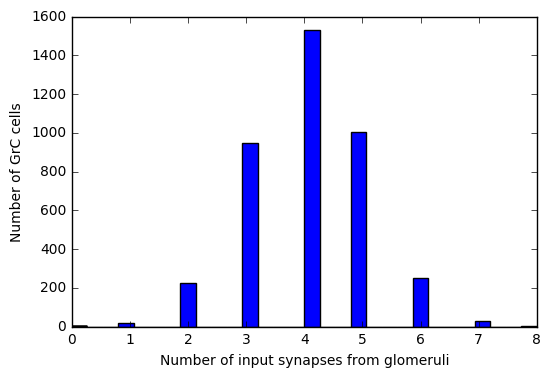

In [7]:
target_cell_index = simulation.cerebellum.layer_map['mfgrcsynapsis'].target_index
cell_number = simulation.cerebellum.layer_map['grclayer'].number_of_neurons
number_of_inputs = numpy.bincount(target_cell_index)
plt.hist(number_of_inputs, bins=30)
plt.ylabel('Number of GrC cells')
plt.xlabel('Number of input synapses from glomeruli')


Plot the histogram of non-zero weights between MF and GrC

Number of active synapses MF-GrC: 8246


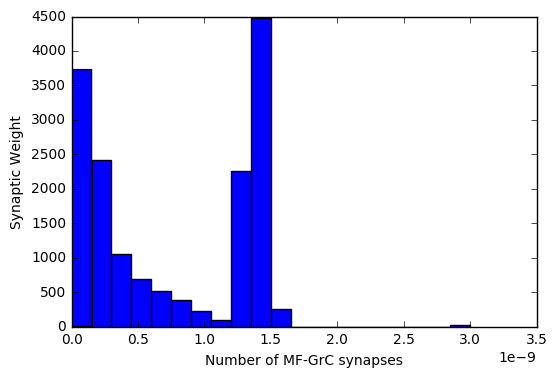

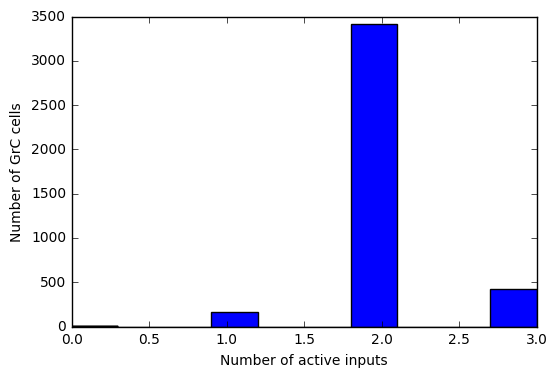

In [8]:
target_cell_index = simulation.cerebellum.layer_map['mfgrcsynapsis'].target_index
source_cell_index = simulation.cerebellum.layer_map['mfgrcsynapsis'].source_index
weight = simulation.cerebellum.layer_map['mfgrcsynapsis'].weights
plt.figure()
plt.hist(weight, bins=20)
plt.ylabel('Synaptic Weight')
plt.xlabel('Number of MF-GrC synapses')
max_weight = numpy.max(weight)
active_synapses = weight>max_weight*0.2
number_of_active_inputs = numpy.bincount(target_cell_index[active_synapses])
plt.figure()
plt.hist(number_of_active_inputs, bins=10)
plt.ylabel('Number of GrC cells')
plt.xlabel('Number of active inputs')
print 'Number of active synapses MF-GrC:',numpy.count_nonzero(active_synapses)


Histogram of active synapses connecting input fibers included in the pattern

[0 1 0 ..., 1 2 1]
Number of active MF-GrC synapses also included in pattern 0 : 1706 . Active neurons: [ 793 3939]
[0 1 1 ..., 1 0 1]
Number of active MF-GrC synapses also included in pattern 1 : 1592 . Active neurons: [ 96 308]
[0 0 0 ..., 1 0 1]
Number of active MF-GrC synapses also included in pattern 2 : 1780 . Active neurons: [ 555  611 1029 1383 2476 3190]
[0 0 0 ..., 1 1 2]
Number of active MF-GrC synapses also included in pattern 3 : 1569 . Active neurons: [ 201  303 2196]


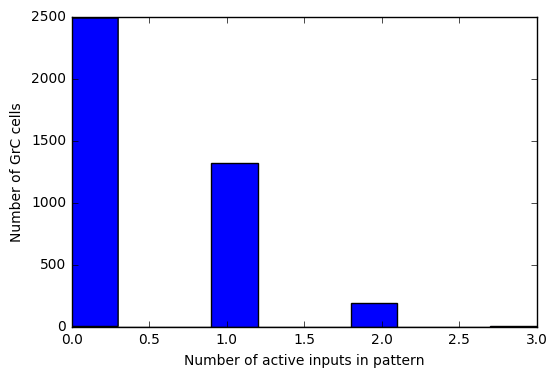

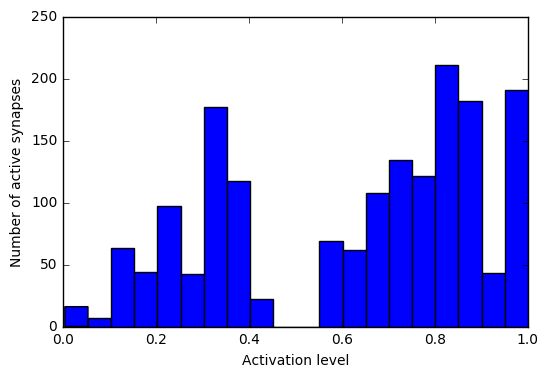

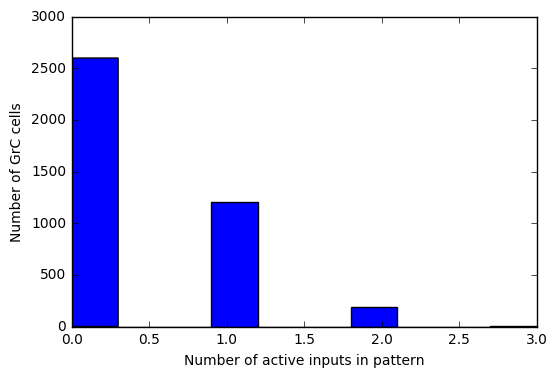

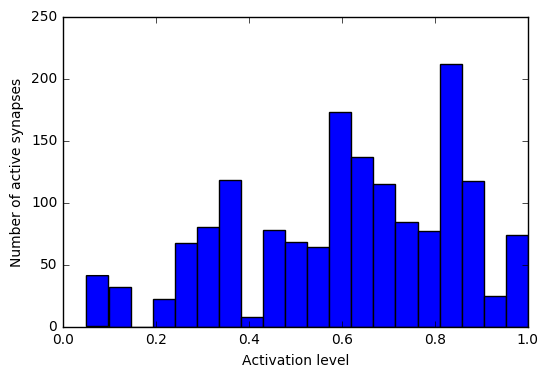

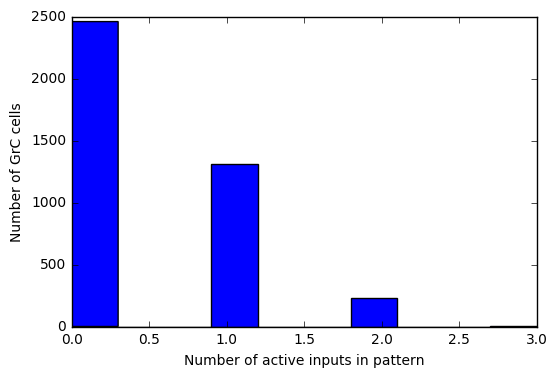

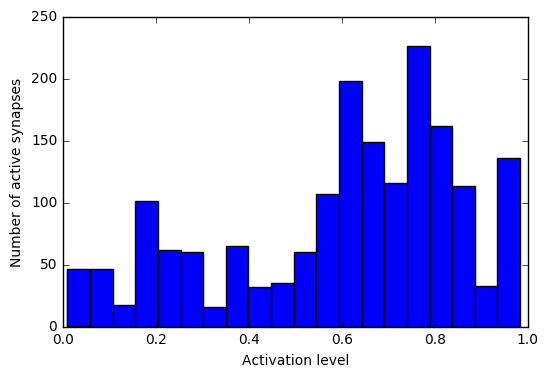

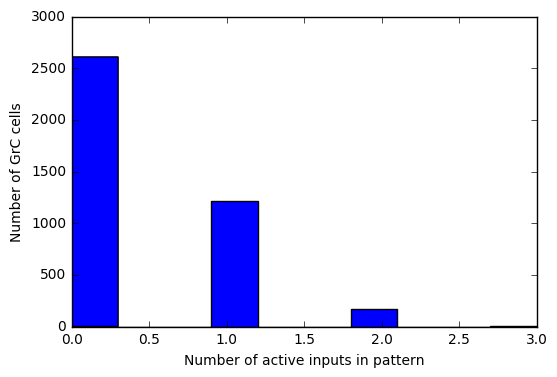

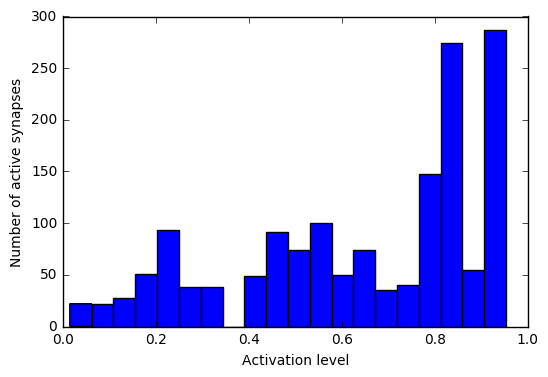

In [9]:
active_target_neurons = []
for pat_id in range(simulation.pattern_generator.number_of_patterns):
    included_in_pattern = numpy.in1d(source_cell_index, simulation.pattern_generator.fibers_in_pattern[pat_id,:])
    included_and_active = numpy.logical_and(included_in_pattern,active_synapses)
    number_of_active_inputs_in_pattern = numpy.bincount(target_cell_index[included_and_active])
    print number_of_active_inputs_in_pattern
    active_target_neurons.append(numpy.where(number_of_active_inputs_in_pattern>=3)[0])
    plt.figure()
    plt.hist(number_of_active_inputs_in_pattern, bins=10)
    plt.ylabel('Number of GrC cells')
    plt.xlabel('Number of active inputs in pattern')
    print 'Number of active MF-GrC synapses also included in pattern',pat_id,':', numpy.count_nonzero(included_and_active), '. Active neurons:', active_target_neurons[pat_id]
    plt.figure()
    simulation.pattern_generator.fibers_in_pattern[0,:]
    activation_level = [simulation.pattern_generator.pattern_activation[pat_id,numpy.where(simulation.pattern_generator.fibers_in_pattern[pat_id,:]==source)[0][0]] 
                    for source in source_cell_index[included_and_active]]
    plt.hist(activation_level, bins=20)
    plt.ylabel('Number of active synapses')
    plt.xlabel('Activation level')

Define some auxiliar functions:

In [10]:
def calc_Ind_Pattern_Hit_Matrix(cell_firing, pattern_present):
    '''
    Calculate the correct rejection, hit, miss and false alarm matrisses with 1 line for each cell and 1 column for each pattern (including noise).
    @param cell_firing Boolean matrix including 1 line for each cell and 1 column for each time bin.
    @param pattern_present Boolean matrix including 1 line for each pattern and 1 column for each time bin.
    '''
    hit_matrix = numpy.empty((len(pattern_present),len(cell_firing)))
    cr_matrix = numpy.empty((len(pattern_present),len(cell_firing)))
    miss_matrix = numpy.empty((len(pattern_present),len(cell_firing)))
    fa_matrix = numpy.empty((len(pattern_present),len(cell_firing)))
    faa_matrix = numpy.empty((len(cell_firing)))
    
    for index_pat, pattern in enumerate(pattern_present):
        if (numpy.count_nonzero(pattern)):
            for index_cell, firing in enumerate(cell_firing):
                hit_matrix[index_pat,index_cell] = numpy.count_nonzero(firing&pattern)/float(numpy.count_nonzero(pattern))
                cr_matrix[index_pat,index_cell] = numpy.count_nonzero(~firing&~pattern)/float(numpy.count_nonzero(~pattern))
                miss_matrix[index_pat,index_cell] = numpy.count_nonzero(~firing&pattern)/float(numpy.count_nonzero(pattern))
                fa_matrix[index_pat,index_cell] = numpy.count_nonzero(firing&~pattern)/float(numpy.count_nonzero(~pattern))
        else:
            print 'Pattern',index_pat,'never occurs. Statistics will not be calculated'
               
    any_pattern = numpy.any(pattern_present, axis=0)
    for index_cell, firing in enumerate(cell_firing):
        faa_matrix[index_cell] = numpy.count_nonzero(firing&~any_pattern)/float(numpy.count_nonzero(~any_pattern))
        
    return cr_matrix, hit_matrix, miss_matrix, fa_matrix, faa_matrix

def analyze_activity(layer, window_length, time_bin):

    cell_index = range(simulation.cerebellum.get_number_of_elements(layer=layer))
    pattern_generator = simulation.pattern_generator
    inv_time_bin = 1./time_bin

    # Generate the time bin matrix
    total_time = pattern_generator.simulation_time
    bin_time_init = numpy.linspace(0.0, window_length-time_bin, num=window_length*inv_time_bin)
    bin_time_end = numpy.linspace(time_bin,window_length,num=window_length*inv_time_bin)

    # Initialize a matrix
    pattern_index = range(0,pattern_generator.number_of_patterns)
    num_patterns = len(pattern_index)
    num_bins = len(bin_time_init)
    num_cells = len(cell_index)

    # Calculate the time of each pattern interval
    time_end_of_pattern = pattern_generator.pattern_length_cum
    time_init_of_pattern = numpy.append([0.0],time_end_of_pattern[:-1])

    # Calculate the bin of each pattern interval. Check the round of the last bin to avoid out of range
    bin_end_of_pattern = numpy.floor(time_end_of_pattern * inv_time_bin).astype(int)
    if (bin_end_of_pattern[-1]>=num_bins):
        bin_end_of_pattern[-1]=num_bins-1
    bin_init_of_pattern = numpy.append([0],bin_end_of_pattern[:-1])
    if (bin_init_of_pattern[-1]>=num_bins):
        bin_init_of_pattern[-1]=num_bins-1

    # Final matrix indicating which bins are considered of each pattern
    bin_is_pattern = numpy.empty((num_patterns, num_bins),dtype='bool')
    bin_is_pattern[:,:] = False
    bin_pattern = numpy.zeros(num_bins)

    # Final matrix indicating which bins are registered spikes
    bin_has_fired = numpy.empty((num_cells, num_bins), dtype='bool')
    bin_has_fired[:,:] = False

    for key, value in enumerate(pattern_index):
        time_of_pattern_in_bin = numpy.zeros(num_bins)
        for index in pattern_generator.pattern_id_index[value]:
            init_bin = bin_init_of_pattern[index]
            end_bin = bin_end_of_pattern[index]

            list_of_bins = range(init_bin,end_bin+1)

            # Add the time of the initial bin (if exists)
            if init_bin!=end_bin:
                time_of_pattern_in_bin[list_of_bins[0]] += (bin_time_end[init_bin] - time_init_of_pattern[index])

            # Add the time of the intermediate bins (if exist)
            time_of_pattern_in_bin[list_of_bins[1:-1]] += time_bin

            # Add the time of the final bin
            time_of_pattern_in_bin[list_of_bins[-1]] += (time_end_of_pattern[index] - max(time_init_of_pattern[index],bin_time_init[end_bin]))

        # Those bins where the time in the pattern is longer than half of the bin are set to part of that pattern    
        bin_is_pattern[key,time_of_pattern_in_bin>(time_bin/2.)] = True
        bin_pattern[bin_is_pattern[key,:]] = bin_pattern[bin_is_pattern[key,:]] + 2**value

    # Create a map of cells to index
    cell_map = dict()
    for key, value in enumerate(cell_index):
        cell_map[value] = key

    # Load data from the data provider
    gtime,gcell_id = simulation.cerebellum.get_spike_activity(neuron_layer = layer, init_time = 0.0, end_time = window_length)


    spike_bin_index = numpy.floor(gtime*inv_time_bin).astype(int)

    av_firing_rate = float(len(gtime))/(len(cell_index)*(window_length))
    print 'Average firing rate in MI analysis:',av_firing_rate,'Hz'

    cell_index = numpy.array([cell_map[value] for value in gcell_id])

    # Final matrix indicating which bins are registered spikes
    if len(spike_bin_index) and len(cell_index):
        bin_has_fired[cell_index,spike_bin_index] = True

    # Calculate mutual information in the time window
    init_bin = int(0 * inv_time_bin)
    end_bin = int(window_length * inv_time_bin)


    # Calculate hit matrix for each pattern
    cr_matrix, hit_matrix, miss_matrix, fa_matrix, faa_matrix = calc_Ind_Pattern_Hit_Matrix(bin_has_fired[:,init_bin:end_bin], bin_is_pattern[:,init_bin:end_bin])

    return cr_matrix, hit_matrix, miss_matrix, fa_matrix, faa_matrix

Represent the hit rate matrix of each GrC to each pattern

Average firing rate in MI analysis: 8.974204 Hz
Pattern: 0 . Neuron: 793 . Hit rate: [ 0.98918387  0.99712368  0.99676375  0.99698189]
Pattern: 0 . Neuron: 3939 . Hit rate: [ 1.          0.99808245  1.          0.99798793]
Pattern: 1 . Neuron: 96 . Hit rate: [ 0.99803343  0.99904123  1.          0.99899396]
Pattern: 1 . Neuron: 308 . Hit rate: [ 0.99705015  1.          0.99676375  1.        ]
Pattern: 2 . Neuron: 555 . Hit rate: [ 0.53097345  0.41610738  0.61920173  0.52313883]
Pattern: 2 . Neuron: 611 . Hit rate: [ 0.98721731  0.99616491  0.99892125  0.99295775]
Pattern: 2 . Neuron: 1029 . Hit rate: [ 0.99705015  1.          0.9978425   0.99899396]
Pattern: 2 . Neuron: 1383 . Hit rate: [ 0.99705015  0.99904123  1.          0.99899396]
Pattern: 2 . Neuron: 2476 . Hit rate: [ 0.98721731  0.99712368  1.          0.99295775]
Pattern: 2 . Neuron: 3190 . Hit rate: [ 0.5280236   0.41610738  0.61488673  0.52012072]
Pattern: 3 . Neuron: 201 . Hit rate: [ 1.  1.  1.  1.]
Pattern: 3 . Neuron: 30

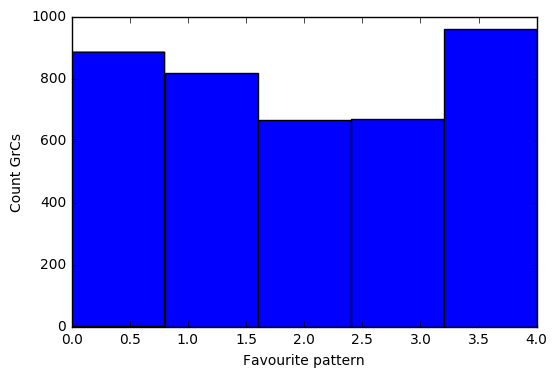

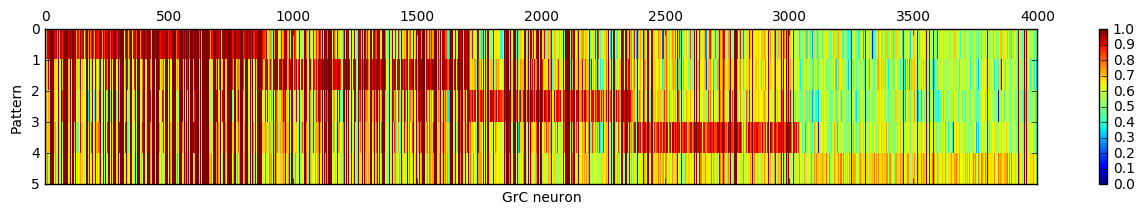

In [22]:
layer = 'grclayer'
window_length = simulation.config_options['hit_analysis']['window_length'] = simulation_time
time_bin = simulation.config_options['hit_analysis']['time_bin'] = 0.125

cr_matrix, hit_matrix, miss_matrix, fa_matrix, faa_matrix = analyze_activity(layer, window_length, time_bin)

#numpy.set_printoptions(threshold=numpy.nan)
#print 'Individual pattern hit matrix:'
#print hit_matrix
#print 'Individual pattern correct rejection matrix:'
#print cr_matrix
#print 'Individual pattern miss matrix:'
#print miss_matrix
#print 'Individual pattern false alarm matrix:'
#print fa_matrix
#print 'All patterns false alarm array:'
#print faa_matrix

for pat_id, neuron_id_list in enumerate(active_target_neurons):
    for neuron in neuron_id_list:
        print 'Pattern:', pat_id, '. Neuron:', neuron, '. Hit rate:', hit_matrix[:,neuron]

extended_hit = numpy.append(hit_matrix, [faa_matrix], axis=0)
selected_pattern = numpy.argmax(extended_hit, axis=0)
plt.figure()
n,bins,_=plt.hist(selected_pattern, bins=simulation.pattern_generator.number_of_patterns+1)
plt.ylabel('Count GrCs')
plt.xlabel('Favourite pattern')
cell_sorted = numpy.argsort(selected_pattern)
plt.figure()
plt.matshow(extended_hit[:,cell_sorted], extent=[0,simulation.cerebellum.get_number_of_elements(layer=layer),
                                                 simulation.pattern_generator.number_of_patterns+1,0], 
            vmin=0, vmax=1.0, aspect='auto')
plt.ylabel('Pattern')
plt.xlabel('GrC neuron')
plt.colorbar()
cells_mult = numpy.prod(n[:-1]/simulation.cerebellum.layer_map['grclayer'].number_of_neurons)
max_mult = pow(1./simulation.pattern_generator.number_of_patterns,simulation.pattern_generator.number_of_patterns)
print 'Product of cell rate assigned to each pattern:', cells_mult, 'over', max_mult

Estimate the goodness of the matrix

Average hits of selected elements: 0.901054651663
Average hits of non-selected elements: 0.581016592635
Average false alarm: 0.749307516578
Difference hit-false alarms per cell: [ 0.25569889  0.00349334  0.16371377 ...,  0.03936783  0.00299401
  0.00234663]
Hit index: 0.320038059028


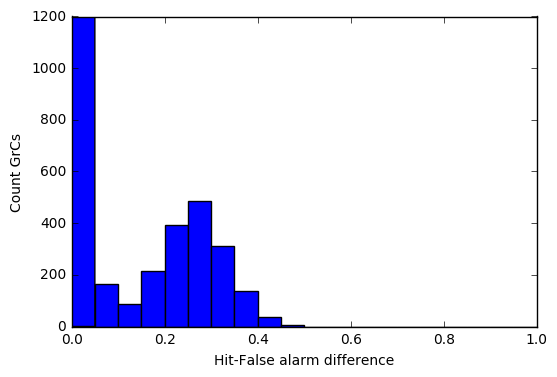

In [24]:
extended_hit = numpy.append(hit_matrix, [faa_matrix], axis=0)
selected_pattern = numpy.argmax(extended_hit, axis=0)

# Select those cells mainly responding to one of the patterns
ind = numpy.where(selected_pattern<simulation.pattern_generator.number_of_patterns)

diagonal = hit_matrix[selected_pattern[ind],ind]
fa_diagonal = fa_matrix[selected_pattern[ind],ind]
hit_fa_diff_per_cell = diagonal[0] - fa_diagonal[0]

# Create a new matrix setting the diagonal values to zero
zero_matrix = numpy.copy(hit_matrix)
zero_matrix[selected_pattern[ind],ind] = 0.0

# Calculate the average of the diagonal elements
av_selected = numpy.average(diagonal)
av_nonselected = numpy.sum(zero_matrix[:])/(simulation.cerebellum.get_number_of_elements(layer=layer)*(simulation.pattern_generator.number_of_patterns))
av_fa_selected = numpy.average(fa_diagonal)
print 'Average hits of selected elements:',av_selected
print 'Average hits of non-selected elements:',av_nonselected
print 'Average false alarm:',av_fa_selected
print 'Difference hit-false alarms per cell:', hit_fa_diff_per_cell
hit_index = av_selected - av_nonselected
print 'Hit index:',hit_index
plt.figure()
plt.hist(hit_fa_diff_per_cell, bins=20, range=(0,1))
plt.ylabel('Count GrCs')
plt.xlabel('Hit-False alarm difference')

## GoC activity analysis

Calculate the average firing frequency of each Golgi cells during the ending 100 seconds

In [ ]:
gtime,gcell_id = simulation.cerebellum.get_spike_activity(neuron_layer = 'goclayer',
                                                          init_time = simulation.current_time-simulation_time, 
                                                          end_time = simulation.current_time)
import numpy
firing_frequency = numpy.bincount(gcell_id) / (simulation_time*8.0)
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(firing_frequency, bins=20)
plt.ylabel('Number of GoC cells')
plt.xlabel('Av. Spikes per Oscillatory Cycle')

Get the histogram of input synapses for the Golgi cells

In [ ]:
target_cell_index = simulation.cerebellum.layer_map['mfgocsynapsis'].target_index
cell_number = simulation.cerebellum.layer_map['goclayer'].number_of_neurons
number_of_inputs = numpy.bincount(target_cell_index)
plt.hist(number_of_inputs, bins=30)
plt.ylabel('Number of GoC cells')
plt.xlabel('Number of input synapses from glomeruli')

Plot the histogram of non-zero weights between MF and GoC

In [ ]:
target_cell_index = simulation.cerebellum.layer_map['mfgocsynapsis'].target_index
source_cell_index = simulation.cerebellum.layer_map['mfgocsynapsis'].source_index
weight = simulation.cerebellum.layer_map['mfgocsynapsis'].weights
plt.figure()
plt.hist(weight, bins=20)
plt.ylabel('Synaptic Weight')
plt.xlabel('Number of MF-GoC synapses')
max_weight = numpy.max(weight)
active_synapses = weight>max_weight*0.2
number_of_active_inputs = numpy.bincount(target_cell_index[active_synapses])
plt.figure()
plt.hist(number_of_active_inputs, bins=10)
plt.ylabel('Number of GoC cells')
plt.xlabel('Number of active inputs')
print 'Number of active synapses MF-GoC:',numpy.count_nonzero(active_synapses)

Histogram of active synapses connecting input fibers included in the pattern

In [ ]:
for pat_id in range(simulation.pattern_generator.number_of_patterns):
    included_in_pattern = numpy.in1d(source_cell_index, simulation.pattern_generator.fibers_in_pattern[pat_id,:])
    included_and_active = numpy.logical_and(included_in_pattern,active_synapses)
    number_of_active_inputs_in_pattern = numpy.bincount(target_cell_index[included_and_active])
    plt.figure()
    plt.hist(number_of_active_inputs_in_pattern, bins=10)
    plt.ylabel('Number of GoC cells')
    plt.xlabel('Number of active inputs in pattern')
    print 'Number of active MF-GoC synapses also included in pattern',pat_id,':', numpy.count_nonzero(included_and_active)
    plt.figure()
    simulation.pattern_generator.fibers_in_pattern[0,:]
    activation_level = [simulation.pattern_generator.pattern_activation[pat_id,numpy.where(simulation.pattern_generator.fibers_in_pattern[pat_id,:]==source)[0][0]] 
                    for source in source_cell_index[included_and_active]]
    plt.hist(activation_level, bins=20)
    plt.ylabel('Number of active synapses')
    plt.xlabel('Activation level')

Represent the hit rate matrix of each GoC to each pattern

In [ ]:
layer = 'goclayer'
window_length = simulation.config_options['hit_analysis']['window_length'] = simulation_time
time_bin = simulation.config_options['hit_analysis']['time_bin'] = 0.125

cr_matrix, hit_matrix, miss_matrix, fa_matrix, faa_matrix = analyze_activity(layer, window_length, time_bin)

#numpy.set_printoptions(threshold=numpy.nan)
#print 'Individual pattern hit matrix:'
#print hit_matrix
#print 'Individual pattern correct rejection matrix:'
#print cr_matrix
#print 'Individual pattern miss matrix:'
#print miss_matrix
#print 'Individual pattern false alarm matrix:'
#print fa_matrix
#print 'All patterns false alarm array:'
#print faa_matrix

extended_hit = numpy.append(hit_matrix, [faa_matrix], axis=0)
selected_pattern = numpy.argmax(extended_hit, axis=0)
plt.figure()
plt.hist(selected_pattern, bins=simulation.pattern_generator.number_of_patterns+1)
plt.ylabel('Count GoCs')
plt.xlabel('Favourite pattern')
cell_sorted = numpy.argsort(selected_pattern)
plt.figure()
plt.matshow(extended_hit[:,cell_sorted], extent=[0,simulation.cerebellum.get_number_of_elements(layer=layer),0,simulation.pattern_generator.number_of_patterns+1], vmin=0, vmax=1.0, aspect='auto')
plt.ylabel('Pattern')
plt.xlabel('GoC neuron')
plt.colorbar()

Estimate the goodness of the matrix

In [ ]:
extended_hit = numpy.append(hit_matrix, [faa_matrix], axis=0)
selected_pattern = numpy.argmax(extended_hit, axis=0)

# Select those cells mainly responding to one of the patterns
ind = numpy.where(selected_pattern<simulation.pattern_generator.number_of_patterns)

diagonal = hit_matrix[selected_pattern[ind],ind]

# Create a new matrix setting the diagonal values to zero
zero_matrix = numpy.copy(hit_matrix)
zero_matrix[selected_pattern[ind],ind] = 0.0

# Calculate the average of the diagonal elements
av_selected = numpy.average(diagonal)
av_nonselected = numpy.sum(zero_matrix[:])/(simulation.cerebellum.get_number_of_elements(layer=layer)*(simulation.pattern_generator.number_of_patterns))
print 'Average hits of selected elements:',av_selected
print 'Average hits of non-selected elements:',av_nonselected
hit_index = av_selected - av_nonselected
print 'Hit index:',hit_index

## PC activity analysis

Histogram of active synapses GrC-PC

In [ ]:
target_cell_index = simulation.cerebellum.layer_map['grcpcsynapsis'].target_index
source_cell_index = simulation.cerebellum.layer_map['grcpcsynapsis'].source_index
weight = simulation.cerebellum.layer_map['grcpcsynapsis'].weights
plt.figure()
plt.hist(weight, bins=20)
plt.ylabel('Number of GrC-PC synapses')
plt.xlabel('Synaptic Weight')
max_weight = numpy.max(weight)
active_synapses = weight>max_weight*0.2
number_of_active_inputs = numpy.bincount(target_cell_index[active_synapses])
plt.figure()
plt.hist(number_of_active_inputs, bins=10)
plt.ylabel('Number of PC cells')
plt.xlabel('Number of active inputs')
print 'Number of active synapses GrC-PC:',numpy.count_nonzero(active_synapses)